 # Librerias

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os

from collections import defaultdict
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Funciones

In [59]:
def remove_correlated_features(X, threshold):
    # Eliminar columnas constantes
    X = X.loc[:, X.apply(pd.Series.nunique) > 1]
    # Calcular la matriz de correlación absoluta
    corr_matrix = X.corr().abs()
    # Seleccionar la parte superior de la matriz de correlación
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Identificar las columnas a eliminar para evitar la correlación alta
    to_drop = set()
    for column in upper.columns:
        # Obtener las columnas correlacionadas con la actual
        correlated_columns = [col for col in upper.columns if upper[col][column] > threshold]
        # Si hay columnas correlacionadas, eliminar todas excepto la primera
        if correlated_columns:
            to_drop.update(correlated_columns[1:])

    # Eliminar las columnas correlacionadas
    return X.drop(columns=list(to_drop), errors='ignore')

In [80]:
def get_frequent_features(features_array):
# seleccionar los m features que mas se repitan en cada experimento
    flattened = np.concatenate([np.unique(row) for row in features_array])
    unique_feats, counts = np.unique(flattened, return_counts=True)
    mean_feats = sum(len(row) for row in features_array) / len(features_array)
    print('Mean features:', mean_feats)

    sorted_indices = np.argsort(-counts)  # Índices ordenados por frecuencia (descendente)
    freq_feat = unique_feats[sorted_indices][:int(np.ceil(mean_feats))]

    return freq_feat.tolist()

In [61]:
def dnn_model(num_entradas, num_clases):
    model = Sequential()
    # Capa de entrada
    model.add(InputLayer(input_shape=(num_entradas,)))
    # Capas ocultas
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    # Capa de salida
    if num_clases == 2:
        # Para clasificación binaria
        model.add(Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    else:
        # Para clasificación multiclase
        model.add(Dense(num_clases, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'
    # Compilar el modelo
    model.compile(optimizer='RMSprop', loss=loss, metrics=['accuracy'])
    # devolver modelo compilado
    return model

In [62]:
def cnn_model_1d(n_features, num_clases):
    model = Sequential()
    # Capa de entrada
    # model.add(InputLayer(input_shape=(input_shape,)))
    # Capa de entrada y primeras capas convolucionales 1D
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_features, 1)))
    # model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(64, kernel_size=3, activation='relu'))

    model.add(Conv1D(128, kernel_size=3, activation='relu'))

    # Aplanar el volumen para conectarlo con capas densas
    model.add(Flatten())

    # Capas densas
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))

    # Capa de salida
    if num_clases == 2:
        # Para clasificación binaria
        model.add(Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    else:
        # Para clasificación multiclase
        model.add(Dense(num_clases, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'

    # Compilar el modelo
    model.compile(optimizer='RMSprop', loss=loss, metrics=['accuracy'])

    return model

In [63]:
def show_metrics(y_true, y_pred):
    print('Accuracy:  ', accuracy_score(y_true, y_pred))
    print('Precision: ', precision_score(y_true, y_pred, average='macro'))
    print('Recall:    ', recall_score(y_true, y_pred, average='macro'))
    print('F1:        ', f1_score(y_true, y_pred, average='macro'))
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=None)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Cargar datos

In [64]:
data = pd.read_csv('X-IIoTID_clean.csv')

# Experimento

Experiment:  E1.1__results.pkl
Classes:  class1
Training | Exp. E1.1__results.pkl | Classes class1
Testing | Exp. E1.1__results.pkl | Classes class1
Tiempo test:  0.019278764724731445
Accuracy:   0.9972520204476988
Precision:  0.9621523315629769
Recall:     0.9566916265964865
F1:         0.9593451089281592


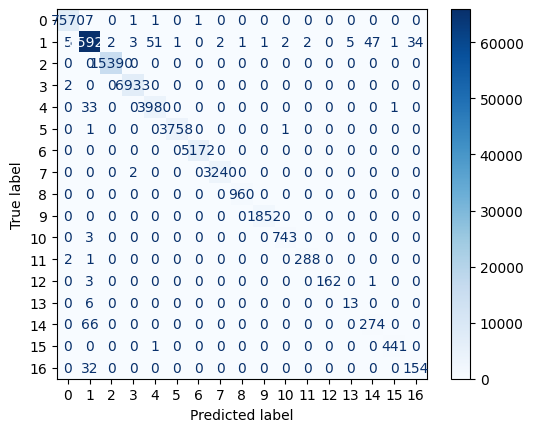

Classes:  class2
Training | Exp. E1.1__results.pkl | Classes class2
Testing | Exp. E1.1__results.pkl | Classes class2
Tiempo test:  0.01639080047607422
Accuracy:   0.9974312365054575
Precision:  0.9959922488443022
Recall:     0.9938585460303339
F1:         0.9949164553057912


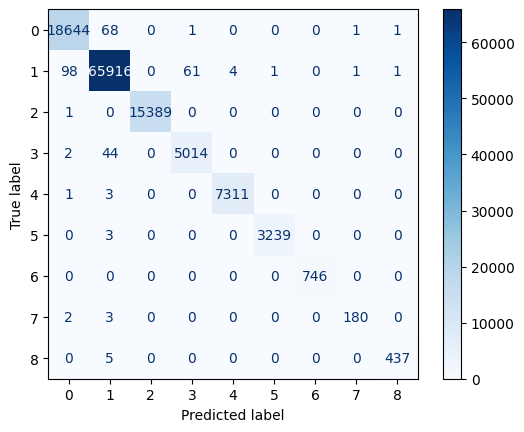

Classes:  class3
Training | Exp. E1.1__results.pkl | Classes class3
Testing | Exp. E1.1__results.pkl | Classes class3
Tiempo test:  0.014732837677001953
Accuracy:   0.9972605545456873
Precision:  0.997194202021431
Recall:     0.9972360796276505
F1:         0.9972151132891433


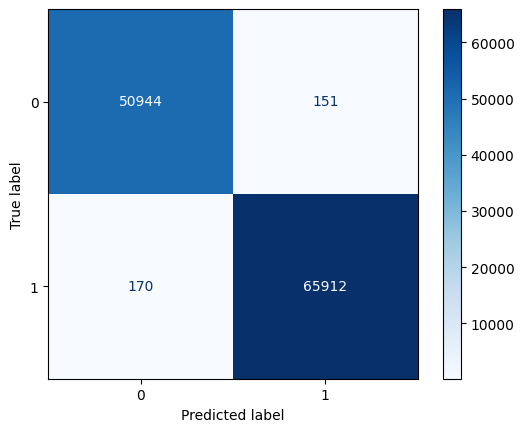

Experiment:  E1.2__results.pkl
Classes:  class1
Training | Exp. E1.2__results.pkl | Classes class1
Testing | Exp. E1.2__results.pkl | Classes class1
Tiempo test:  0.017360687255859375
Accuracy:   0.9973544296235609
Precision:  0.9625486028523542
Recall:     0.9624885082568937
F1:         0.9623552949692046


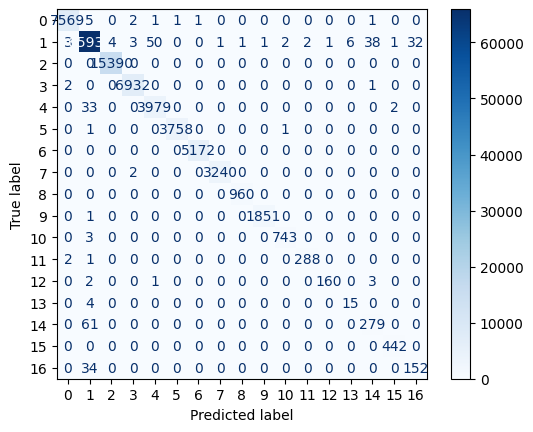

Classes:  class2
Training | Exp. E1.2__results.pkl | Classes class2
Testing | Exp. E1.2__results.pkl | Classes class2
Tiempo test:  0.01653742790222168
Accuracy:   0.997439770603446
Precision:  0.9943758289602825
Recall:     0.9942273897665849
F1:         0.9943012073929931


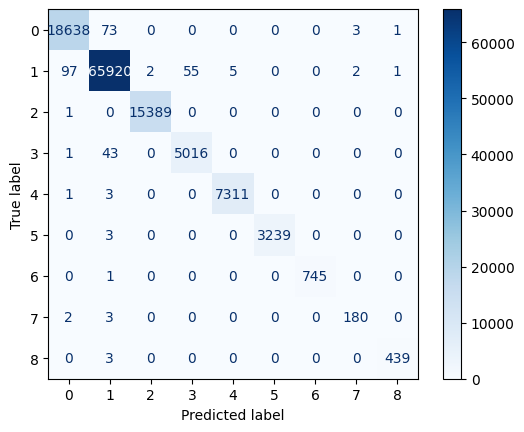

Classes:  class3
Training | Exp. E1.2__results.pkl | Classes class3
Testing | Exp. E1.2__results.pkl | Classes class3
Tiempo test:  0.014465808868408203
Accuracy:   0.9973288273295954
Precision:  0.9972505242705494
Recall:     0.9973188038469133
F1:         0.9972845907586291


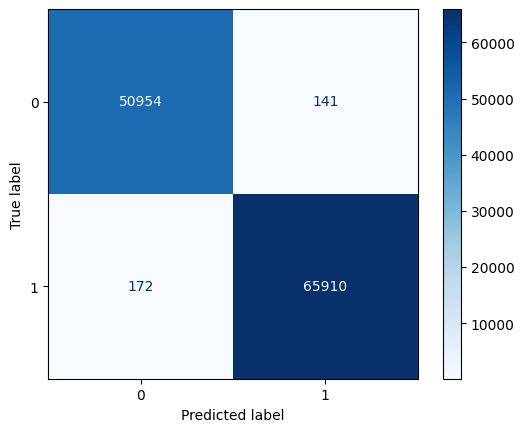

Experiment:  E1.3__results.pkl
Classes:  class1
Mean features: 26.2
Training | Exp. E1.3__results.pkl | Classes class1
Testing | Exp. E1.3__results.pkl | Classes class1
Tiempo test:  0.012181997299194336
Accuracy:   0.9964924857267211
Precision:  0.9727794665812359
Recall:     0.9542390502081721
F1:         0.9627207827502055


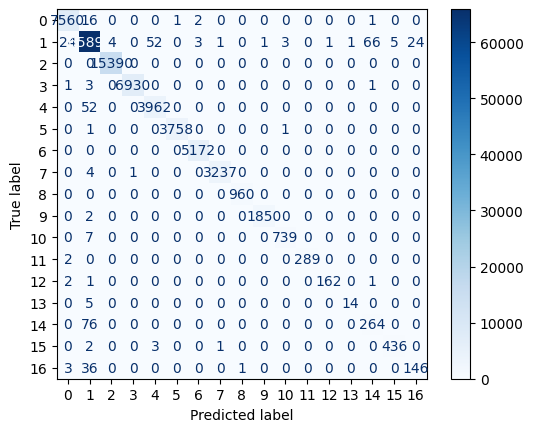

Classes:  class2
Mean features: 24.6
Training | Exp. E1.3__results.pkl | Classes class2
Testing | Exp. E1.3__results.pkl | Classes class2
Tiempo test:  0.010816335678100586
Accuracy:   0.9963644742568935
Precision:  0.9919310430908366
Recall:     0.9925629729836449
F1:         0.9922449956104528


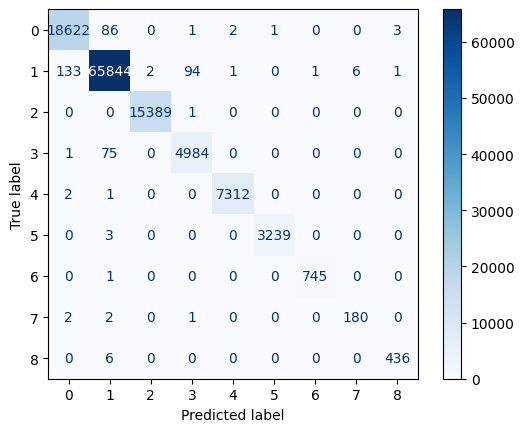

Classes:  class3
Mean features: 29.0
Training | Exp. E1.3__results.pkl | Classes class3
Testing | Exp. E1.3__results.pkl | Classes class3
Tiempo test:  0.010378122329711914
Accuracy:   0.9971922817617792
Precision:  0.997094364710023
Recall:     0.997197742135706
F1:         0.9971458849736308


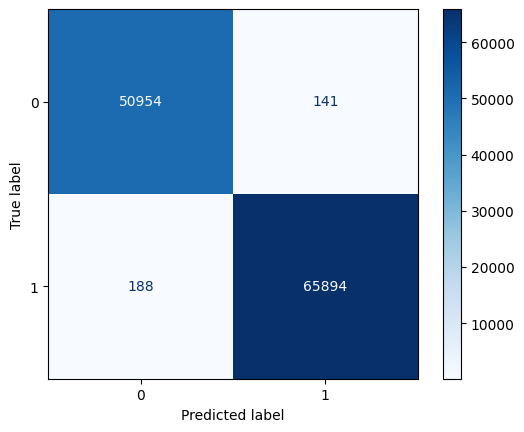

Experiment:  E1.4__results.pkl
Classes:  class1
Mean features: 15.4
Training | Exp. E1.4__results.pkl | Classes class1
Testing | Exp. E1.4__results.pkl | Classes class1
Tiempo test:  0.012296438217163086
Accuracy:   0.9892897070244161
Precision:  0.9289816805380865
Recall:     0.9069079941437199
F1:         0.915184343956772


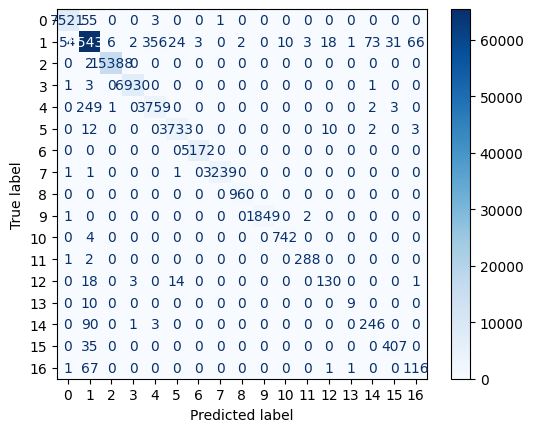

Classes:  class2
Mean features: 11.2
Training | Exp. E1.4__results.pkl | Classes class2
Testing | Exp. E1.4__results.pkl | Classes class2
Tiempo test:  0.009335517883300781
Accuracy:   0.9948198025209726
Precision:  0.9915892112852416
Recall:     0.9891773555298529
F1:         0.9903621221429564


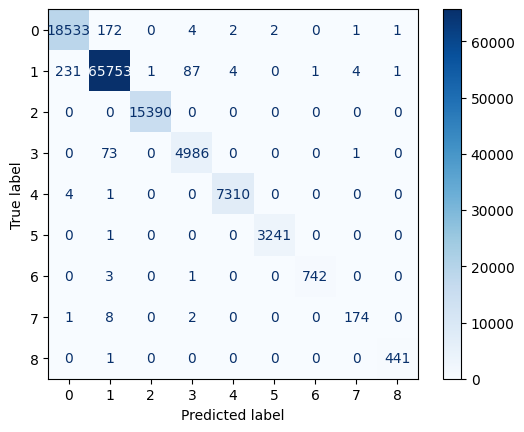

Classes:  class3
Mean features: 12.0
Training | Exp. E1.4__results.pkl | Classes class3
Testing | Exp. E1.4__results.pkl | Classes class3
Tiempo test:  0.007812738418579102
Accuracy:   0.9949648821867773
Precision:  0.9948594667751738
Recall:     0.9949033385349452
F1:         0.9948813722188241


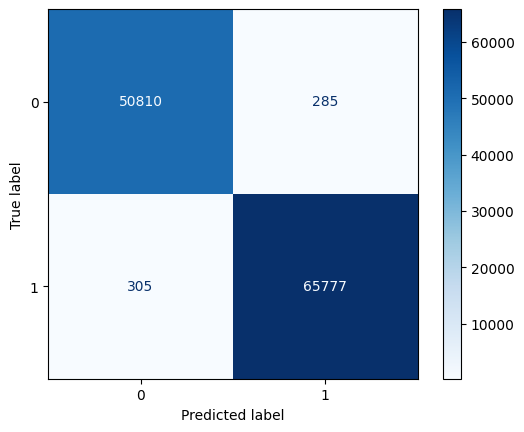

Experiment:  E2.1__results.pkl
Classes:  class1
Training | Exp. E2.1__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1725 - accuracy: 0.9457
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0803 - accuracy: 0.9725
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0627 - accuracy: 0.9773
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0532 - accuracy: 0.9797
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0485 - accuracy: 0.9810
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0454 - accuracy: 0.9820
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0434 - accuracy: 0.9828
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0417 - accuracy: 0.9832
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0404 - 

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 482us/step
Tiempo test:  2.0974860191345215
Accuracy:   0.9844764757588946
Precision:  0.9598980161486262
Recall:     0.9011616580067635
F1:         0.9154769308770456


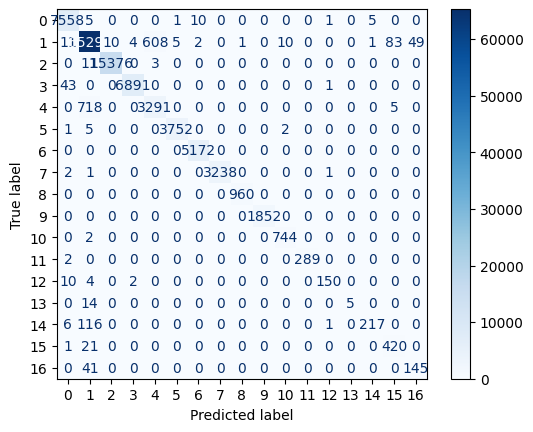

Classes:  class2
Training | Exp. E2.1__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1303 - accuracy: 0.9610
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0667 - accuracy: 0.9780
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0569 - accuracy: 0.9795
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0510 - accuracy: 0.9808
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0477 - accuracy: 0.9815
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0450 - accuracy: 0.9823
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0434 - accuracy: 0.9826
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0420 - accuracy: 0.9832
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0408 - accuracy: 0.9838
Epoch 10/10
18

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 488us/step
Tiempo test:  2.115950584411621
Accuracy:   0.9849373170502743
Precision:  0.9741367448324056
Recall:     0.9735662478122933
F1:         0.9729471411967956


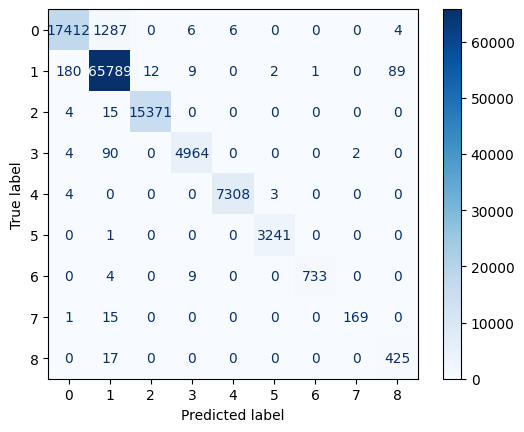

Classes:  class3
Training | Exp. E2.1__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0906 - accuracy: 0.9708
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0564 - accuracy: 0.9799
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0494 - accuracy: 0.9808
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0457 - accuracy: 0.9818
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0429 - accuracy: 0.9827
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0413 - accuracy: 0.9833
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0404 - accuracy: 0.9837
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0392 - accuracy: 0.9840
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0386 - accuracy: 0.9842
Epoch 10/10
18

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 1s 397us/step
Tiempo test:  1.7877204418182373
Accuracy:   0.9859102042209649
Precision:  0.9860683050960313
Recall:     0.9852797309634183
F1:         0.9856643890767967


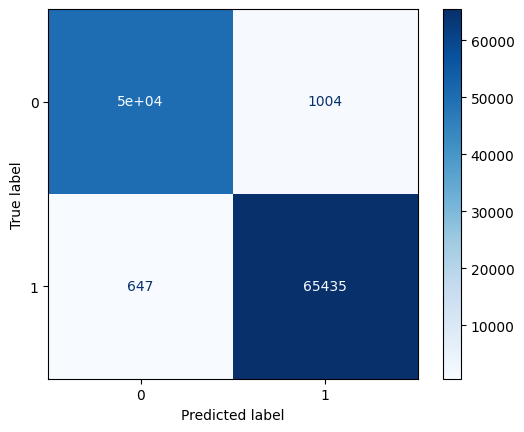

Experiment:  E2.2__results.pkl
Classes:  class1
Training | Exp. E2.2__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1751 - accuracy: 0.9456
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0789 - accuracy: 0.9726
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0618 - accuracy: 0.9773
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0531 - accuracy: 0.9796
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0481 - accuracy: 0.9812
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0454 - accuracy: 0.9824
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0430 - accuracy: 0.9832
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0415 - accuracy: 0.9834
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0403 - 

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 482us/step
Tiempo test:  2.09675669670105
Accuracy:   0.9853810901456771
Precision:  0.9676043247400838
Recall:     0.8966529206550085
F1:         0.9153272844270445


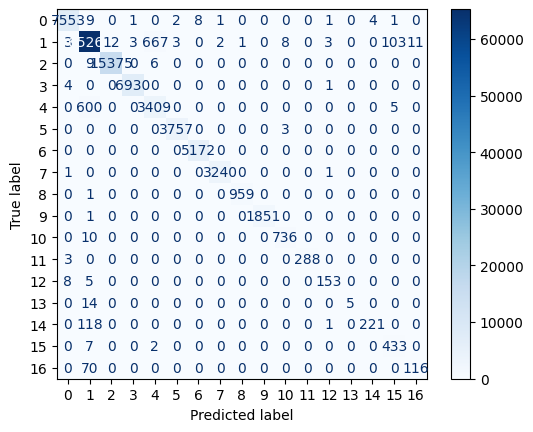

Classes:  class2
Training | Exp. E2.2__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1321 - accuracy: 0.9607
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0663 - accuracy: 0.9779
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0571 - accuracy: 0.9795
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0511 - accuracy: 0.9806
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0472 - accuracy: 0.9818
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0446 - accuracy: 0.9827
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0428 - accuracy: 0.9830
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0418 - accuracy: 0.9834
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0408 - accuracy: 0.9837
Epoch 10/10
18

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 473us/step
Tiempo test:  2.069704294204712
Accuracy:   0.9794157556517064
Precision:  0.964956912578287
Recall:     0.9692756595872868
F1:         0.9649139280829312


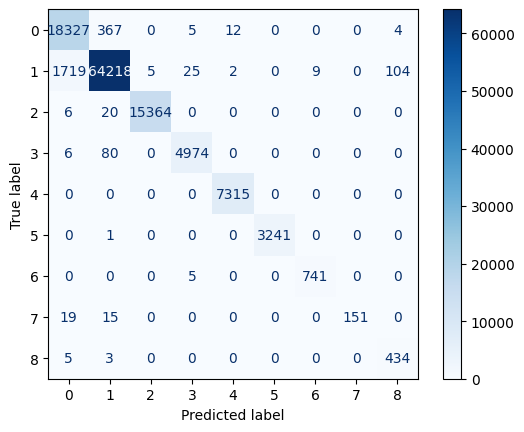

Classes:  class3
Training | Exp. E2.2__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0918 - accuracy: 0.9705
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0565 - accuracy: 0.9797
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0493 - accuracy: 0.9808
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0454 - accuracy: 0.9818
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0429 - accuracy: 0.9825
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0413 - accuracy: 0.9833
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0401 - accuracy: 0.9835
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0392 - accuracy: 0.9839
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0386 - accuracy: 0.9841
Epoch 10/10
18

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 1s 394us/step
Tiempo test:  1.7685651779174805
Accuracy:   0.9839814980755609
Precision:  0.9841479991344606
Recall:     0.9832767818923145
F1:         0.9837006238772192


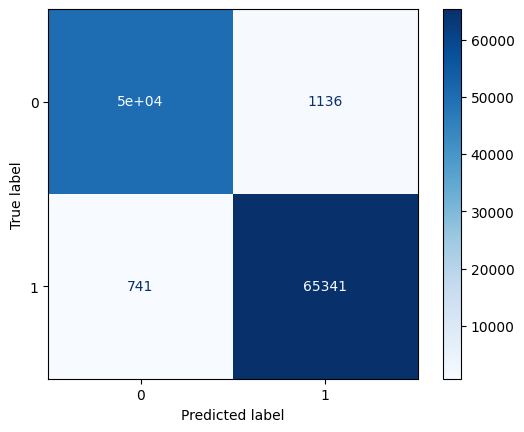

Experiment:  E2.3__results.pkl
Classes:  class1
Mean features: 27.2
Training | Exp. E2.3__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2550 - accuracy: 0.9160
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1204 - accuracy: 0.9550
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0998 - accuracy: 0.9608
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0888 - accuracy: 0.9641
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0813 - accuracy: 0.9670
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0765 - accuracy: 0.9687
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0724 - accuracy: 0.9705
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0690 - accuracy: 0.9722
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/st

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 471us/step
Tiempo test:  2.0454819202423096
Accuracy:   0.9776747996620497
Precision:  0.9171847098098632
Recall:     0.8673146014887712
F1:         0.8873755391256195


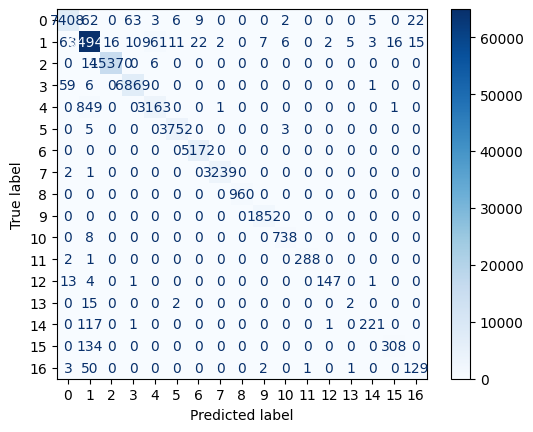

Classes:  class2
Mean features: 27.4
Training | Exp. E2.3__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2121 - accuracy: 0.9291
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1092 - accuracy: 0.9623
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0963 - accuracy: 0.9661
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0894 - accuracy: 0.9680
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0846 - accuracy: 0.9694
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0817 - accuracy: 0.9699
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0792 - accuracy: 0.9707
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0778 - accuracy: 0.9711
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0760 - accuracy: 0

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 475us/step
Tiempo test:  2.0501160621643066
Accuracy:   0.9660854945936489
Precision:  0.9623041226455089
Recall:     0.9370625974539356
F1:         0.9437988440012072


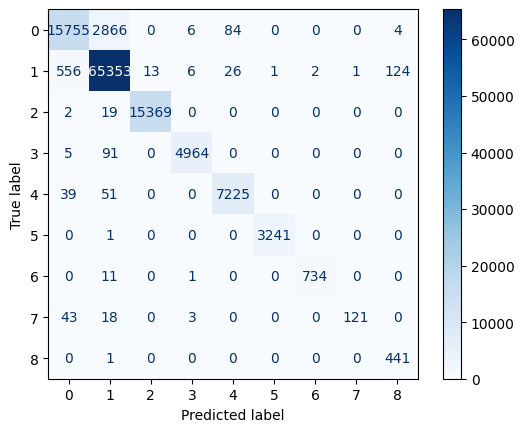

Classes:  class3
Mean features: 29.2
Training | Exp. E2.3__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1511 - accuracy: 0.9423
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0856 - accuracy: 0.9662
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0731 - accuracy: 0.9701
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0671 - accuracy: 0.9718
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0633 - accuracy: 0.9735
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0609 - accuracy: 0.9742
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0593 - accuracy: 0.9749
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0580 - accuracy: 0.9752
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0569 - accuracy: 0

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 1s 369us/step
Tiempo test:  1.6610219478607178
Accuracy:   0.9787244937146369
Precision:  0.9786824456495757
Recall:     0.9780433172284275
F1:         0.9783563596985896


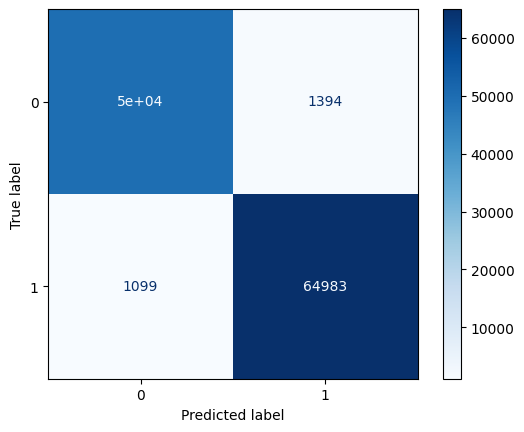

Experiment:  E2.4__results.pkl
Classes:  class1
Mean features: 13.6
Training | Exp. E2.4__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4161 - accuracy: 0.8575
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2610 - accuracy: 0.9044
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2175 - accuracy: 0.9221
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1908 - accuracy: 0.9317
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1752 - accuracy: 0.9365
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1648 - accuracy: 0.9390
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1562 - accuracy: 0.9418
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1496 - accuracy: 0.9442
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/st

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 475us/step
Tiempo test:  2.044257402420044
Accuracy:   0.9515092552292685
Precision:  0.8556340607561044
Recall:     0.7485572459105435
F1:         0.7808238227322016


/home/ubuntu2202/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


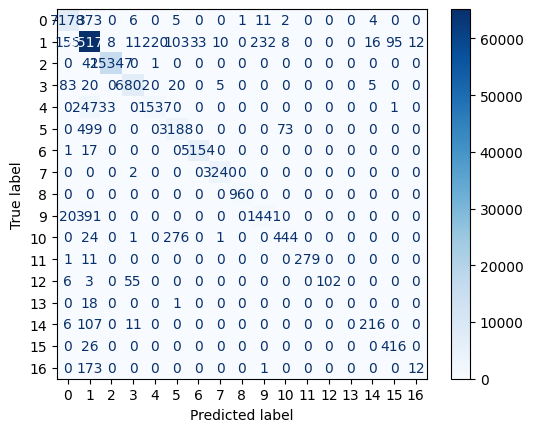

Classes:  class2
Mean features: 12.2
Training | Exp. E2.4__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4377 - accuracy: 0.8340
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2858 - accuracy: 0.8873
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2399 - accuracy: 0.9091
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2114 - accuracy: 0.9217
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1931 - accuracy: 0.9300
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1806 - accuracy: 0.9349
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1714 - accuracy: 0.9385
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1642 - accuracy: 0.9411
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1574 - accuracy: 0

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 465us/step
Tiempo test:  2.0093507766723633
Accuracy:   0.9531392679450745
Precision:  0.9227465561724455
Recall:     0.9027925331233629
F1:         0.9105172559447277


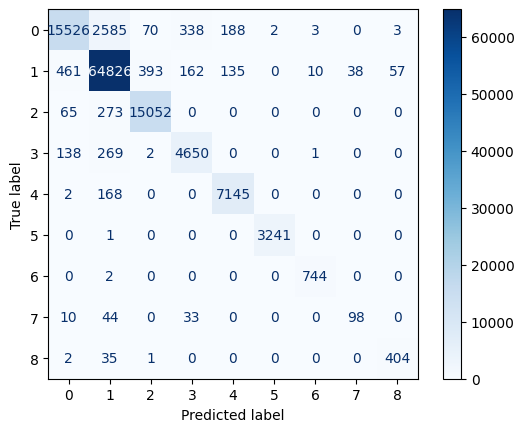

Classes:  class3
Mean features: 12.2
Training | Exp. E2.4__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3964 - accuracy: 0.7918
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2529 - accuracy: 0.8933
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2225 - accuracy: 0.9105
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2077 - accuracy: 0.9181
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1973 - accuracy: 0.9233
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1898 - accuracy: 0.9265
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1837 - accuracy: 0.9290
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1767 - accuracy: 0.9317
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1718 - accuracy: 0

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 1s 364us/step
Tiempo test:  1.6368324756622314
Accuracy:   0.9377864256637395
Precision:  0.9424018565003978
Recall:     0.9322332079364108
F1:         0.9360958103344995


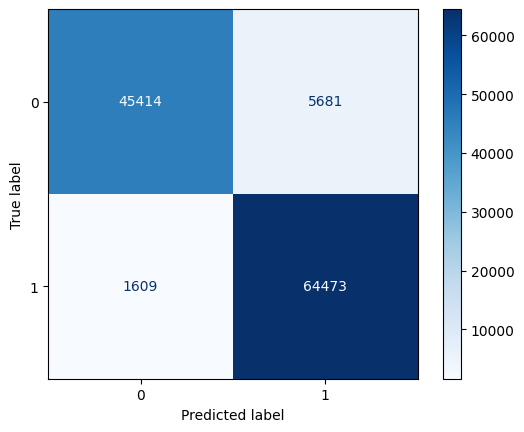

Experiment:  E3.1__results.pkl
Classes:  class1
Training | Exp. E3.1__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.1553 - accuracy: 0.9542
Epoch 2/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0630 - accuracy: 0.9784
Epoch 3/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0465 - accuracy: 0.9822
Epoch 4/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0391 - accuracy: 0.9846
Epoch 5/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0350 - accuracy: 0.9862
Epoch 6/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0323 - accuracy: 0.9869
Epoch 7/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0302 - accuracy: 0.9879
Epoch 8/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0291 - accuracy: 0.9882
Epoch 9/10
1875/1875 [==============================] - 25s 13ms/step

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 4s 1ms/step
Tiempo test:  4.556528329849243
Accuracy:   0.9888544680270018
Precision:  0.9742189993177145
Recall:     0.9145150814690131
F1:         0.9348384576112135


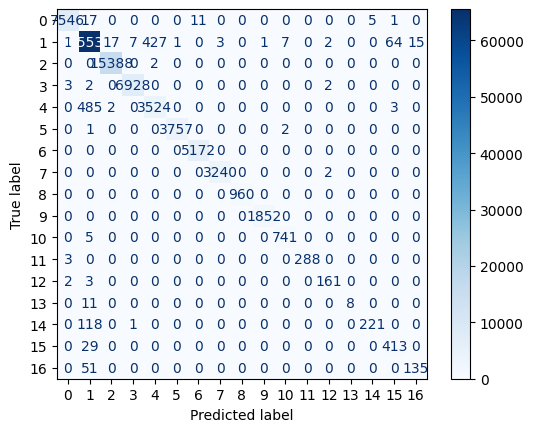

Classes:  class2
Training | Exp. E3.1__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1269 - accuracy: 0.9634
Epoch 2/10
1875/1875 [==============================] - 25s 14ms/step - loss: 0.0592 - accuracy: 0.9799
Epoch 3/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0482 - accuracy: 0.9815
Epoch 4/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0421 - accuracy: 0.9835
Epoch 5/10
1875/1875 [==============================] - 25s 14ms/step - loss: 0.0378 - accuracy: 0.9849
Epoch 6/10
1875/1875 [==============================] - 25s 14ms/step - loss: 0.0346 - accuracy: 0.9861
Epoch 7/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0325 - accuracy: 0.9870
Epoch 8/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0308 - accuracy: 0.9875
Epoch 9/10
1875/1875 [==============================] - 25s 14ms/step - loss: 0.0293 - accuracy: 0.9

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 4s 1ms/step
Tiempo test:  4.567966938018799
Accuracy:   0.9857224540652175
Precision:  0.9719757313785199
Recall:     0.9866193829363432
F1:         0.9779766226132196


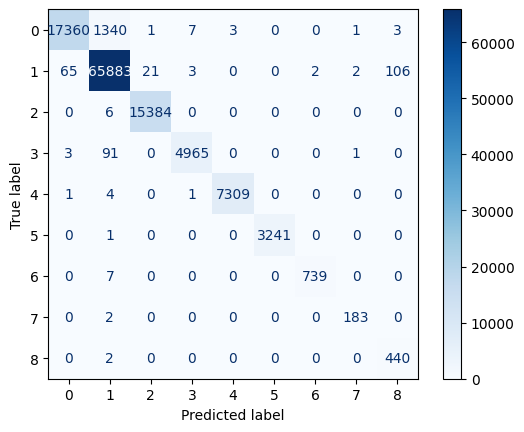

Classes:  class3
Training | Exp. E3.1__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0981 - accuracy: 0.9669
Epoch 2/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0490 - accuracy: 0.9815
Epoch 3/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0401 - accuracy: 0.9840
Epoch 4/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0358 - accuracy: 0.9855
Epoch 5/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0333 - accuracy: 0.9865
Epoch 6/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0315 - accuracy: 0.9871
Epoch 7/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0304 - accuracy: 0.9875
Epoch 8/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0291 - accuracy: 0.9880
Epoch 9/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0280 - accuracy: 0.9

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 4s 1ms/step
Tiempo test:  4.4320759773254395
Accuracy:   0.9889824794968296
Precision:  0.9894558688916992
Recall:     0.9881634116839283
F1:         0.9887847166589459


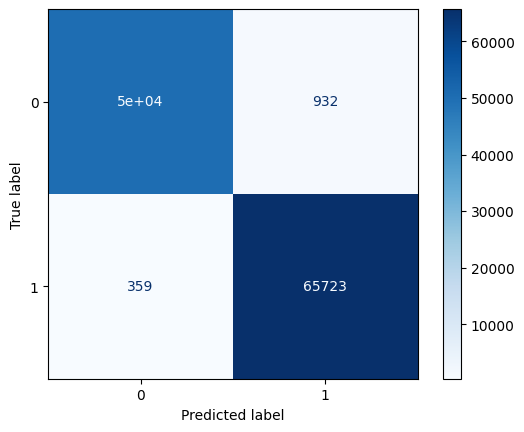

Experiment:  E3.2__results.pkl
Classes:  class1
Training | Exp. E3.2__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1557 - accuracy: 0.9539
Epoch 2/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0600 - accuracy: 0.9790
Epoch 3/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0443 - accuracy: 0.9830
Epoch 4/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0378 - accuracy: 0.9852
Epoch 5/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0338 - accuracy: 0.9864
Epoch 6/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0310 - accuracy: 0.9876
Epoch 7/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0295 - accuracy: 0.9881
Epoch 8/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0282 - accuracy: 0.9889
Epoch 9/10
1875/1875 [==============================] - 24s 13ms/step

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 4s 1ms/step
Tiempo test:  4.551929712295532
Accuracy:   0.9897676165117728
Precision:  0.972521050288426
Recall:     0.9286308212329368
F1:         0.9471142385732996


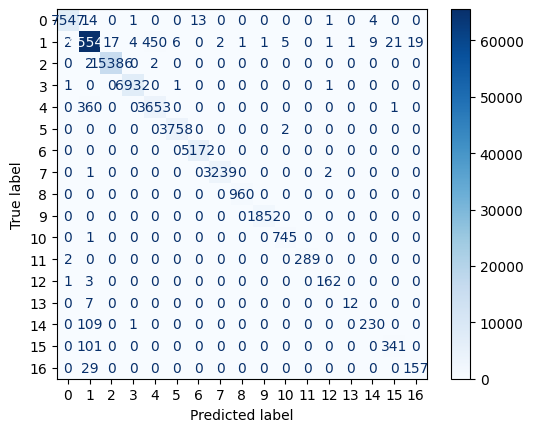

Classes:  class2
Training | Exp. E3.2__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.1216 - accuracy: 0.9643
Epoch 2/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0553 - accuracy: 0.9803
Epoch 3/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0452 - accuracy: 0.9825
Epoch 4/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0382 - accuracy: 0.9847
Epoch 5/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0343 - accuracy: 0.9863
Epoch 6/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0325 - accuracy: 0.9869
Epoch 7/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0308 - accuracy: 0.9875
Epoch 8/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0292 - accuracy: 0.9882
Epoch 9/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0280 - accuracy: 0.9

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 4s 1ms/step
Tiempo test:  4.5200395584106445
Accuracy:   0.9871220461353337
Precision:  0.9782269091491695
Recall:     0.9778266366135502
F1:         0.9774213375653645


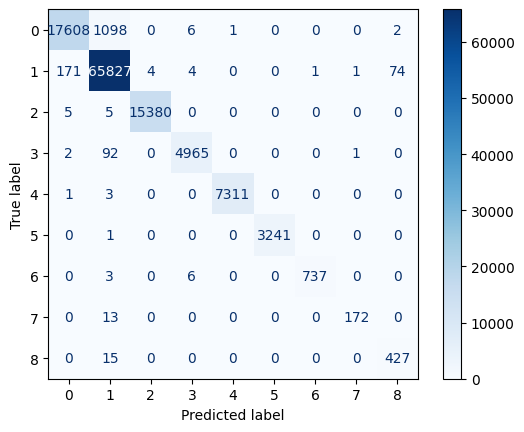

Classes:  class3
Training | Exp. E3.2__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0964 - accuracy: 0.9677
Epoch 2/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0482 - accuracy: 0.9815
Epoch 3/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0403 - accuracy: 0.9840
Epoch 4/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0365 - accuracy: 0.9855
Epoch 5/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0342 - accuracy: 0.9861
Epoch 6/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0326 - accuracy: 0.9867
Epoch 7/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0310 - accuracy: 0.9874
Epoch 8/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0297 - accuracy: 0.9878
Epoch 9/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0284 - accuracy: 0.9

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 4s 1ms/step
Tiempo test:  4.570559501647949
Accuracy:   0.9893323775143587
Precision:  0.9889546543058277
Recall:     0.9893702442107271
F1:         0.9891596057202476


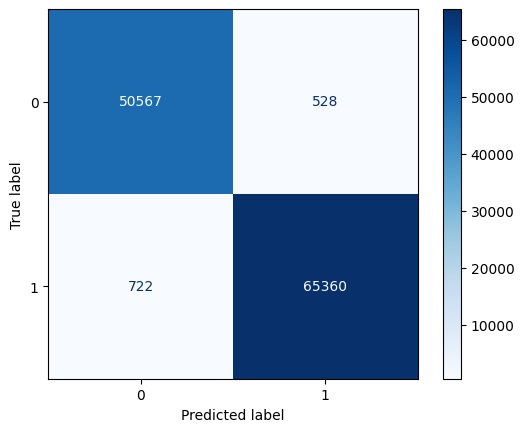

Experiment:  E3.3__results.pkl
Classes:  class1
Mean features: 30.8
Training | Exp. E3.3__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2262 - accuracy: 0.9226
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1056 - accuracy: 0.9594
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0843 - accuracy: 0.9664
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0709 - accuracy: 0.9713
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0632 - accuracy: 0.9747
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0588 - accuracy: 0.9765
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0558 - accuracy: 0.9775
Epoch 8/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0540 - accuracy: 0.9783
Epoch 9/10
1875/1875 [==============================] - 1

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 4s 950us/step
Tiempo test:  3.826042652130127
Accuracy:   0.9794157556517064
Precision:  0.9616440265804359
Recall:     0.8855559599452857
F1:         0.9091256333307363


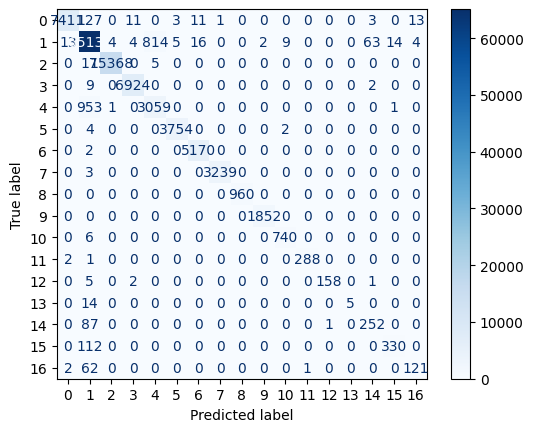

Classes:  class2
Mean features: 25.4
Training | Exp. E3.3__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2056 - accuracy: 0.9308
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0967 - accuracy: 0.9662
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0844 - accuracy: 0.9691
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0741 - accuracy: 0.9712
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0675 - accuracy: 0.9731
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0634 - accuracy: 0.9748
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0602 - accuracy: 0.9760
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0575 - accuracy: 0.9767
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0555 - ac

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 3s 923us/step
Tiempo test:  3.717533588409424
Accuracy:   0.9779820271896362
Precision:  0.9579846628088762
Recall:     0.9533517960722173
F1:         0.9556218100412068


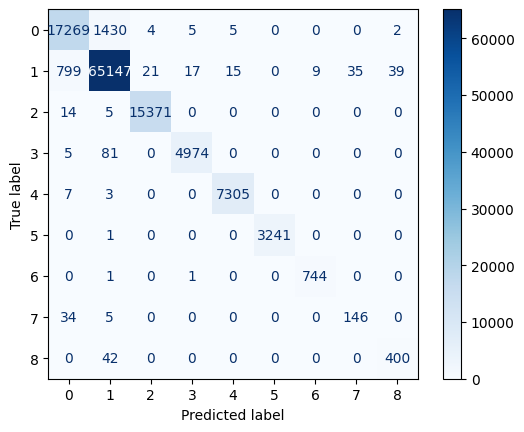

Classes:  class3
Mean features: 28.0
Training | Exp. E3.3__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1372 - accuracy: 0.9470
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0749 - accuracy: 0.9699
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0651 - accuracy: 0.9735
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0604 - accuracy: 0.9752
Epoch 5/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0570 - accuracy: 0.9765
Epoch 6/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0549 - accuracy: 0.9771
Epoch 7/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0532 - accuracy: 0.9777
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0520 - accuracy: 0.9782
Epoch 9/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0507 - ac

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 3s 902us/step
Tiempo test:  3.633132219314575
Accuracy:   0.9792024032019936
Precision:  0.9804140152452845
Recall:     0.9774239451256725
F1:         0.978793148638363


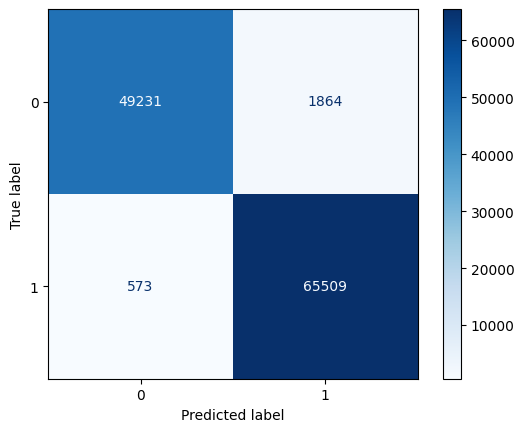

Experiment:  E3.4__results.pkl
Classes:  class1
Mean features: 13.6
Training | Exp. E3.4__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.7039 - accuracy: 0.7770
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4672 - accuracy: 0.8431
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3826 - accuracy: 0.8704
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3225 - accuracy: 0.8895
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2790 - accuracy: 0.9040
Epoch 6/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2516 - accuracy: 0.9139
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2312 - accuracy: 0.9209
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2152 - accuracy: 0.9261
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/st

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 3s 808us/step
Tiempo test:  3.2964766025543213
Accuracy:   0.9396383249272469
Precision:  0.7121751184282797
Recall:     0.6348252154702891
F1:         0.6474597965101553


/home/ubuntu2202/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


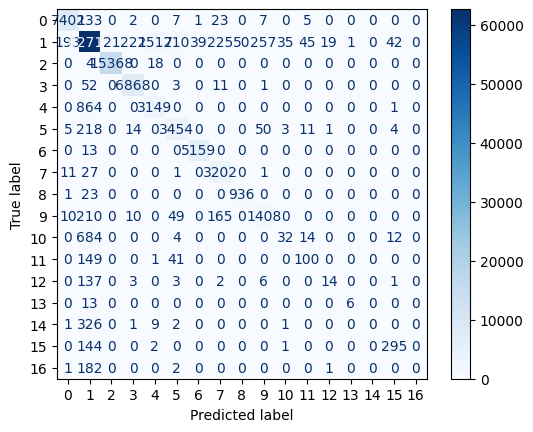

Classes:  class2
Mean features: 14.8
Training | Exp. E3.4__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2888 - accuracy: 0.8957
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1496 - accuracy: 0.9484
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1273 - accuracy: 0.9544
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1122 - accuracy: 0.9595
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1031 - accuracy: 0.9625
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0964 - accuracy: 0.9647
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0913 - accuracy: 0.9661
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0873 - accuracy: 0.9673
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0848 - accuracy: 0

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 3s 812us/step
Tiempo test:  3.2950611114501953
Accuracy:   0.9644554818778429
Precision:  0.9710962477674419
Recall:     0.8427161766588332
F1:         0.8803386009044498


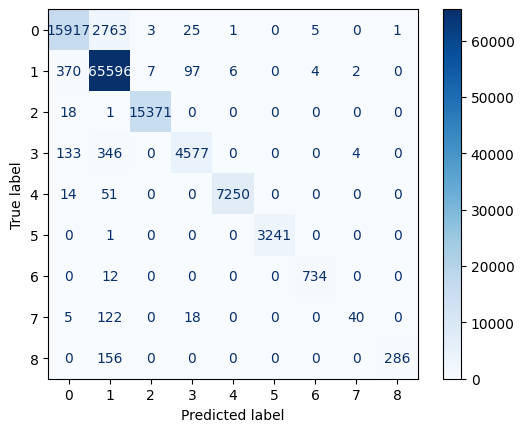

Classes:  class3
Mean features: 14.6
Training | Exp. E3.4__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2191 - accuracy: 0.9181
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1548 - accuracy: 0.9376
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1287 - accuracy: 0.9482
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1146 - accuracy: 0.9547
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1066 - accuracy: 0.9575
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1015 - accuracy: 0.9595
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0975 - accuracy: 0.9610
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0947 - accuracy: 0.9619
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0914 - accuracy: 0

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 3s 764us/step
Tiempo test:  3.131866455078125
Accuracy:   0.9641823907422105
Precision:  0.9645951995040656
Recall:     0.9625514021003638
F1:         0.9635088104090446


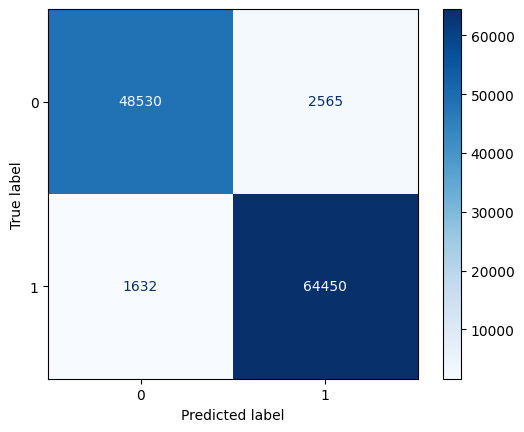

In [88]:
scaler = MinMaxScaler()

exp_names = ['E1.1__results.pkl','E1.2__results.pkl','E1.3__results.pkl','E1.4__results.pkl',
        'E2.1__results.pkl','E2.2__results.pkl','E2.3__results.pkl','E2.4__results.pkl',
        'E3.1__results.pkl','E3.2__results.pkl','E3.3__results.pkl','E3.4__results.pkl']

keys = ['class1', 'class2', 'class3']
exclude_cols = ['class1', 'class2', 'class3', 'Date', 'Timestamp', 'Scr_IP', 'Des_IP']

X_orig = data.drop(columns=exclude_cols)

# iterar sobre experimentos
for exp in exp_names:
    print('Experiment: ', exp)
    # Cargar el archivo .pkl
    with open(exp, 'rb') as file:
        exp_results = pickle.load(file)

    # iterar sobre tipos de clases
    for key in keys:
        print('Classes: ', key)
        
        ### Filtrar features ###
        if '.3' in exp or '.4' in exp:
            freq_feat = get_frequent_features(exp_results[key]['features']) # features frecuentes del experimento/clase
            X_mod = X_orig.iloc[:, freq_feat] # filtar features en X_orig
        elif '.1' in exp:
            X_mod = X_orig
        # dividir sets en train y test
        x_tr, x_te, y_tr, y_te = train_test_split(
            X_mod, data[key], test_size=0.2, random_state=42, stratify=data[key]
        )
        
        ### eliminar columnas correlacionadas en exp x.2 ###
        if '.2' in exp:
            x_tr = remove_correlated_features(x_tr, 0.99)
            x_te = x_te[x_tr.columns]

        ### Escalar ###
        x_tr = scaler.fit_transform(x_tr)
        x_te = scaler.transform(x_te)
        
        ### Guardar para pruebas en jetson ##
        x_te_df = pd.DataFrame(x_te)
        y_te_df = pd.DataFrame(y_te)
        test_data = pd.concat([x_te_df, y_te_df], axis=1)
        csv_filename = f"{exp}_{key}_test.csv"
        test_data.to_csv(csv_filename, index=False)

        ### Entrenar modelos ###
        # seleccionar clasificador
        if 'E1' in exp:
            classifier = DecisionTreeClassifier()
        elif 'E2' in exp:
            classifier = dnn_model(x_tr.shape[1], y_tr.nunique())
        elif 'E3' in exp:
            classifier = cnn_model_1d(x_tr.shape[1], y_tr.nunique())
        # entrenar
        print(f'Training | Exp. {exp} | Classes {key}')
        if 'E2' in exp or 'E3' in exp:
            classifier.fit(x_tr, y_tr, batch_size=250, epochs=10)
        else:
            classifier.fit(x_tr, y_tr)

        ## Exportar modelo ##
        if isinstance(classifier, DecisionTreeClassifier):
            # Guardar modelo scikit-learn
            with open(f'model_{exp}_{key}.pkl', 'wb') as file:
                pickle.dump(classifier, file)
        elif 'E2' in exp or 'E3' in exp:
            # Guardar modelo de redes neuronales
            classifier.save(f'model_{exp}_{key}.h5')

        ### Testing ###
        # para comparar con jetson
        print(f'Testing | Exp. {exp} | Classes {key}')
        start_time = time.time()
        if 'E2' in exp or 'E3' in exp:
            if key == 'class3':
                start_time = time.time()
                y_pred = (classifier.predict(x_te) > 0.5).astype(int).flatten()
            else:
                start_time = time.time()
                y_pred = np.argmax(classifier.predict(x_te), axis=-1)
        else:
            start_time = time.time()
            y_pred = classifier.predict(x_te)
        test_time = time.time() - start_time        
        print('Tiempo test: ', test_time)
        
        show_metrics(y_te, y_pred)